### ti


In [3]:
# !pip install renishawWiRE
import numpy as np
import matplotlib.pyplot as plt
from renishawWiRE import WDFReader
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import glob
import os

# for deleting cosmic rays
from scipy.ndimage import median_filter


In [4]:
# # loading files to colab
# from google.colab import files

# uploaded = files.upload()

wdf_folder = './wdf'
if not os.path.exists(wdf_folder):
    os.makedirs(wdf_folder)
    print(f"Создана папка: {wdf_folder}")
    print("⚠️  ВНИМАНИЕ: Поместите ваши .wdf файлы в эту папку и запустите блок заново!")
else:
    print(f"✓ Папка {wdf_folder} найдена")
    
# Проверяем наличие файлов
wdf_files = glob.glob(os.path.join(wdf_folder, '*.wdf'))
if len(wdf_files) == 0:
    print(f"\n❌ В папке {wdf_folder} не найдено .wdf файлов!")
    print("Скопируйте ваши файлы в эту папку:")
    print(f"   - {os.path.abspath(wdf_folder)}")
else:
    print(f"\n✓ Найдено {len(wdf_files)} .wdf файлов:")
    for f in wdf_files:
        print(f"   - {os.path.basename(f)}")

✓ Папка ./wdf найдена

✓ Найдено 3 .wdf файлов:
   - cht_light-785-1200-nd10-5s_32x32_map.wdf
   - ad-785-nd10-5s-1200-HR-1.wdf
   - cht_dark-785-1200-nd10-5s_32x32_map.wdf


In [5]:
# Блок 2: Локальная загрузка файлов из папки 'wdf'
def read_wdf_file(filename):
    reader = WDFReader(filename)
    spectra = reader.spectra  # numpy array: shape (num_points, num_channels)
    xdata = reader.xdata  # wavenumbers (Raman shift)

    # Для картирования также получаем координаты
    try:
        xpos = reader.xpos  # X-координаты точек
        ypos = reader.ypos  # Y-координаты точек
        return spectra, xdata, xpos, ypos
    except:
        # Для single-point измерений координат может не быть
        return spectra, xdata, None, None

# Чтение всех .wdf файлов из папки 'wdf'
wdf_folder = './wdf'  # Путь к папке с файлами
filenames = sorted(glob.glob(os.path.join(wdf_folder, '*.wdf')))
print(f"Найдено файлов: {len(filenames)}\n")

data_list = []
file_labels = []  # Список имен файлов для легенд

for i, f in enumerate(filenames):
    basename = os.path.basename(f)
    print(f"[{i+1}] Загрузка файла: {basename}")
    data = read_wdf_file(f)
    data_list.append(data)
    file_labels.append(basename.replace('.wdf', ''))
    print(f"    Размер спектров: {data[0].shape}\n")

print(f"Всего загружено датасетов: {len(data_list)}")
print(f"Метки: {file_labels}")


Найдено файлов: 3

[1] Загрузка файла: ad-785-nd10-5s-1200-HR-1.wdf
    Размер спектров: (32, 32, 1011)

[2] Загрузка файла: cht_dark-785-1200-nd10-5s_32x32_map.wdf
    Размер спектров: (32, 32, 1011)

[3] Загрузка файла: cht_light-785-1200-nd10-5s_32x32_map.wdf
    Размер спектров: (32, 32, 1011)

Всего загружено датасетов: 3
Метки: ['ad-785-nd10-5s-1200-HR-1', 'cht_dark-785-1200-nd10-5s_32x32_map', 'cht_light-785-1200-nd10-5s_32x32_map']


In [6]:
# Блок 3: Удаление полиномиального фона из спектров
def remove_poly_background(spectra, degree=5):
    """
    Удаление полиномиального фона из спектров
    spectra: array формата (n_spectra, n_channels) или (x, y, n_channels)
    """
    original_shape = spectra.shape
    if len(original_shape) == 3:
        spectra_2d = spectra.reshape(-1, original_shape[-1])
    else:
        spectra_2d = spectra

    corrected = np.zeros_like(spectra_2d)
    x = np.arange(spectra_2d.shape[1])

    for i, spectrum in enumerate(spectra_2d):
        coeffs = np.polyfit(x, spectrum, degree)
        background = np.polyval(coeffs, x)
        corrected[i] = spectrum - background

    if len(original_shape) == 3:
        corrected = corrected.reshape(original_shape)

    return corrected

# Применяем к всем датасетам
spectra_cleaned_list = []
for i, data in enumerate(data_list):
    print(f"Удаление фона из датасета {i+1}: {file_labels[i]}...")
    cleaned = remove_poly_background(data[0])
    spectra_cleaned_list.append(cleaned)
    print(f"  Результат: {cleaned.shape}")


Удаление фона из датасета 1: ad-785-nd10-5s-1200-HR-1...
  Результат: (32, 32, 1011)
Удаление фона из датасета 2: cht_dark-785-1200-nd10-5s_32x32_map...
  Результат: (32, 32, 1011)
Удаление фона из датасета 3: cht_light-785-1200-nd10-5s_32x32_map...
  Результат: (32, 32, 1011)


In [7]:
# Блок 4: Удаление выбросов (cosmic ray removal)
def remove_cosmic_rays(spectra, threshold=3.0):
    """
    Удаление космических лучей на основе анализа производной
    """
    original_shape = spectra.shape
    if len(original_shape) == 3:
        spectra_2d = spectra.reshape(-1, original_shape[-1])
    else:
        spectra_2d = spectra.copy()

    cleaned = np.zeros_like(spectra_2d)

    for i, spectrum in enumerate(spectra_2d):
        deriv = np.gradient(spectrum)
        deriv_smooth = savgol_filter(deriv, window_length=5, polyorder=2)
        diff = np.abs(deriv - deriv_smooth)

        threshold_val = threshold * np.std(diff)
        spikes = diff > threshold_val

        spectrum_clean = spectrum.copy()
        if np.any(spikes):
            indices = np.arange(len(spectrum))
            spectrum_clean[spikes] = np.interp(indices[spikes],
                                                indices[~spikes],
                                                spectrum[~spikes])
        cleaned[i] = spectrum_clean

    if len(original_shape) == 3:
        cleaned = cleaned.reshape(original_shape)

    return cleaned

# Применяем удаление cosmic rays ко всем датасетам
spectra_cr_removed_list = []
for i, cleaned in enumerate(spectra_cleaned_list):
    print(f"Удаление cosmic rays из датасета {i+1}: {file_labels[i]}...")
    cr_removed = remove_cosmic_rays(cleaned)
    spectra_cr_removed_list.append(cr_removed)
    print(f"  Результат: {cr_removed.shape}")


Удаление cosmic rays из датасета 1: ad-785-nd10-5s-1200-HR-1...
  Результат: (32, 32, 1011)
Удаление cosmic rays из датасета 2: cht_dark-785-1200-nd10-5s_32x32_map...
  Результат: (32, 32, 1011)
Удаление cosmic rays из датасета 3: cht_light-785-1200-nd10-5s_32x32_map...
  Результат: (32, 32, 1011)


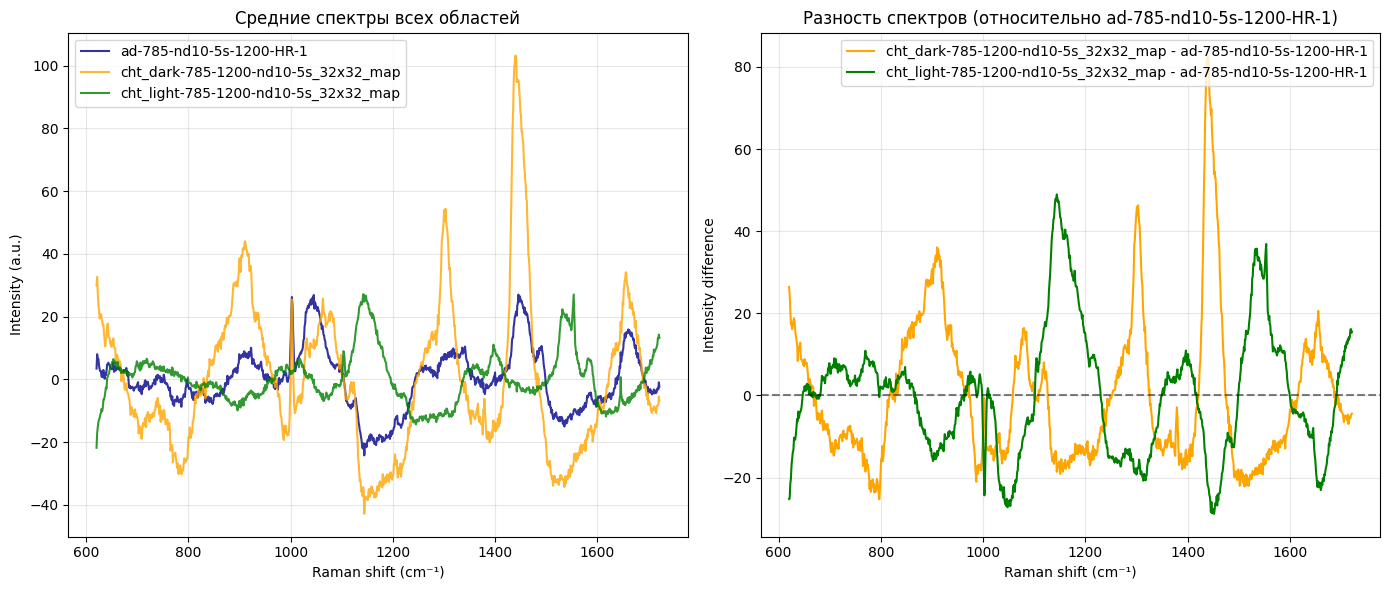

In [8]:
# Блок 5: Визуализация средних спектров для всех областей
def plot_average_spectra_all(spectra_list, labels_list, wavenumbers):
    """
    Построение графика средних спектров для всех областей
    """
    n_datasets = len(spectra_list)
    colors = ['darkblue', 'orange', 'green', 'red', 'purple']  # Цвета для разных датасетов
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # График 1: Все средние спектры
    mean_spectra = []
    for i, data in enumerate(spectra_list):
        data_2d = data.reshape(-1, data.shape[-1])
        mean_spectrum = np.mean(data_2d, axis=0)
        mean_spectra.append(mean_spectrum)
        
        axes[0].plot(wavenumbers, mean_spectrum, 
                    label=labels_list[i], 
                    color=colors[i % len(colors)], 
                    linewidth=1.5, 
                    alpha=0.8)
    
    axes[0].set_xlabel('Raman shift (cm⁻¹)')
    axes[0].set_ylabel('Intensity (a.u.)')
    axes[0].set_title('Средние спектры всех областей')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # График 2: Разности спектров (относительно первого)
    for i in range(1, len(mean_spectra)):
        difference = mean_spectra[i] - mean_spectra[0]
        axes[1].plot(wavenumbers, difference, 
                    label=f'{labels_list[i]} - {labels_list[0]}',
                    color=colors[i % len(colors)], 
                    linewidth=1.5)
    
    axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[1].set_xlabel('Raman shift (cm⁻¹)')
    axes[1].set_ylabel('Intensity difference')
    axes[1].set_title(f'Разность спектров (относительно {labels_list[0]})')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Используем wavenumbers из первого файла
wavenumbers = data_list[0][1]
plot_average_spectra_all(spectra_cr_removed_list, file_labels, wavenumbers)


In [9]:
# Блок 6: Нормализация данных для PCA и ML
def normalize_spectra_map(spectra, method='standard'):
    """
    Нормализация спектров
    """
    original_shape = spectra.shape
    spectra_2d = spectra.reshape(-1, original_shape[-1])

    if method == 'standard':
        scaler = StandardScaler()
        spectra_norm = scaler.fit_transform(spectra_2d)
    elif method == 'minmax':
        from sklearn.preprocessing import MinMaxScaler
        scaler = MinMaxScaler()
        spectra_norm = scaler.fit_transform(spectra_2d)
    elif method == 'vector':
        from sklearn.preprocessing import normalize
        spectra_norm = normalize(spectra_2d, norm='l2')
    else:
        spectra_norm = spectra_2d

    return spectra_norm, original_shape

# Нормализация всех датасетов
norm_list = []
for i, spectra in enumerate(spectra_cr_removed_list):
    print(f"Нормализация датасета {i+1}: {file_labels[i]}...")
    norm, shape = normalize_spectra_map(spectra, method='standard')
    norm_list.append(norm)
    print(f"  Результат: {norm.shape}")

# Объединяем все датасеты для совместного анализа
all_spectra_norm = np.vstack(norm_list)

# Создаем метки для каждого класса (0, 1, 2, ...)
labels = []
for i, norm in enumerate(norm_list):
    labels.extend([i] * norm.shape[0])
labels = np.array(labels)

print(f"\nОбщий датасет: {all_spectra_norm.shape}")
print(f"Метки: {labels.shape}, уникальные классы: {np.unique(labels)}")
print(f"Распределение по классам: {[(file_labels[i], np.sum(labels == i)) for i in range(len(norm_list))]}")


Нормализация датасета 1: ad-785-nd10-5s-1200-HR-1...
  Результат: (1024, 1011)
Нормализация датасета 2: cht_dark-785-1200-nd10-5s_32x32_map...
  Результат: (1024, 1011)
Нормализация датасета 3: cht_light-785-1200-nd10-5s_32x32_map...
  Результат: (1024, 1011)

Общий датасет: (3072, 1011)
Метки: (3072,), уникальные классы: [0 1 2]
Распределение по классам: [('ad-785-nd10-5s-1200-HR-1', np.int64(1024)), ('cht_dark-785-1200-nd10-5s_32x32_map', np.int64(1024)), ('cht_light-785-1200-nd10-5s_32x32_map', np.int64(1024))]


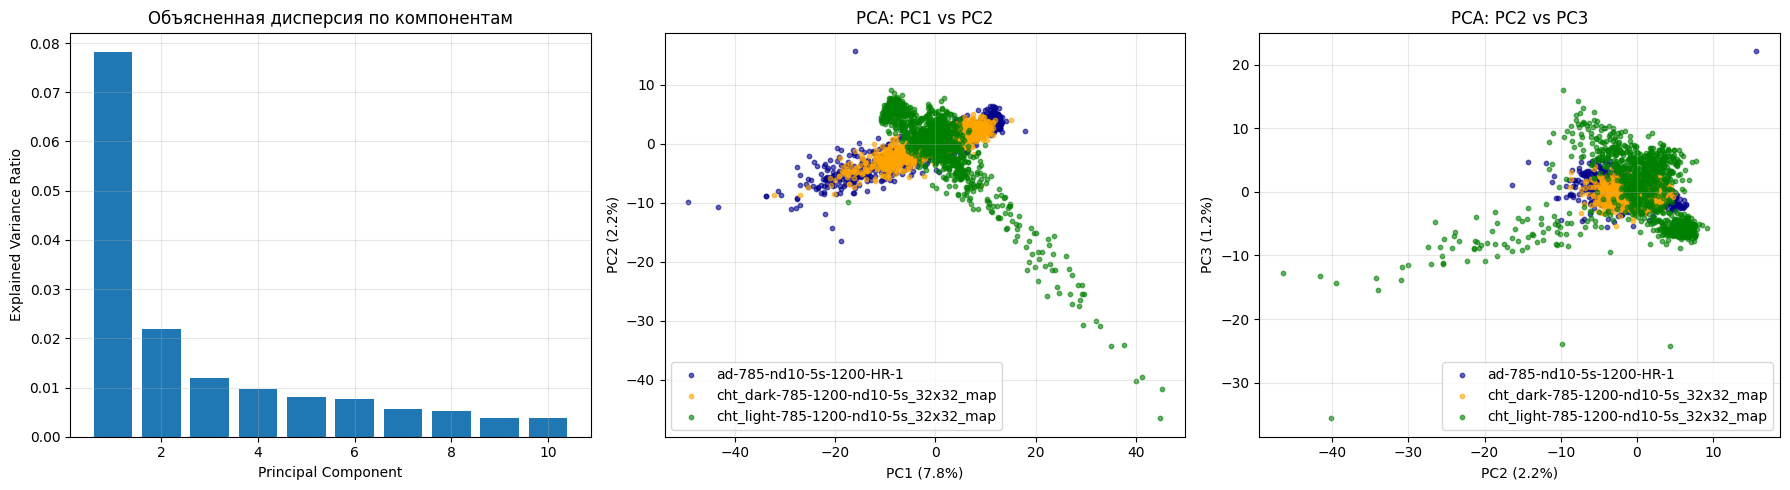


Первые 3 компоненты объясняют 11.2% дисперсии


In [10]:
# Блок 7: PCA анализ и визуализация для 3+ классов
pca = PCA(n_components=10)
pca_result = pca.fit_transform(all_spectra_norm)

explained_var = pca.explained_variance_ratio_
cumsum_var = np.cumsum(explained_var)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# График объясненной дисперсии
axes[0].bar(range(1, 11), explained_var[:10])
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('Объясненная дисперсия по компонентам')
axes[0].grid(alpha=0.3)

# PCA scatter plot (PC1 vs PC2)
colors_map = ['darkblue', 'orange', 'green', 'red', 'purple']
for i in range(len(norm_list)):
    mask = labels == i
    axes[1].scatter(pca_result[mask, 0], pca_result[mask, 1],
                   c=colors_map[i % len(colors_map)], 
                   label=file_labels[i],
                   alpha=0.6, s=10)
axes[1].set_xlabel(f'PC1 ({explained_var[0]*100:.1f}%)')
axes[1].set_ylabel(f'PC2 ({explained_var[1]*100:.1f}%)')
axes[1].set_title('PCA: PC1 vs PC2')
axes[1].legend()
axes[1].grid(alpha=0.3)

# PCA scatter plot (PC2 vs PC3)
for i in range(len(norm_list)):
    mask = labels == i
    axes[2].scatter(pca_result[mask, 1], pca_result[mask, 2],
                   c=colors_map[i % len(colors_map)], 
                   label=file_labels[i],
                   alpha=0.6, s=10)
axes[2].set_xlabel(f'PC2 ({explained_var[1]*100:.1f}%)')
axes[2].set_ylabel(f'PC3 ({explained_var[2]*100:.1f}%)')
axes[2].set_title('PCA: PC2 vs PC3')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nПервые 3 компоненты объясняют {cumsum_var[2]*100:.1f}% дисперсии")


Запуск t-SNE (может занять несколько минут)...


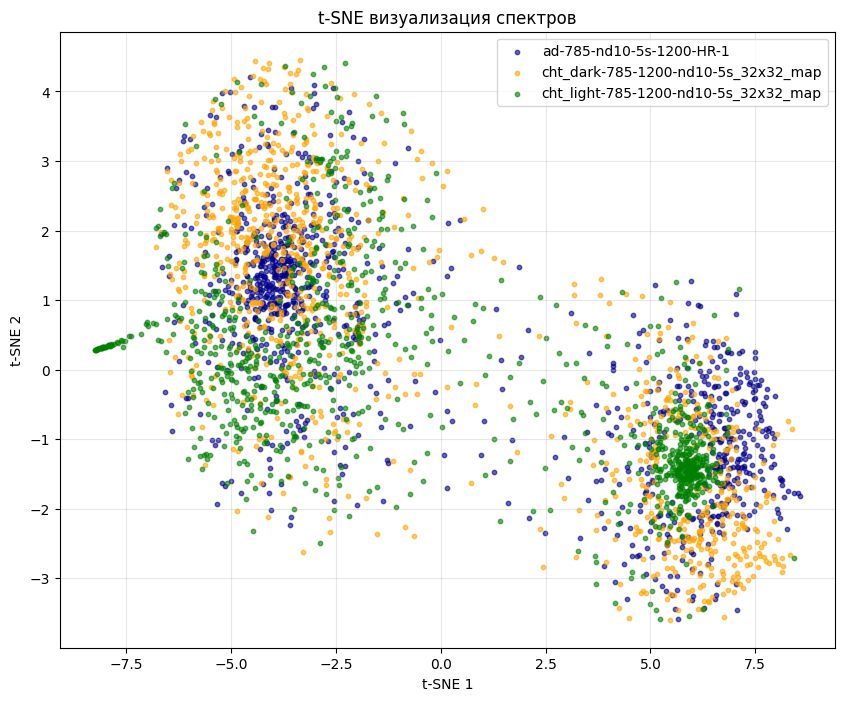

In [12]:
# Блок 8: t-SNE визуализация для 3+ классов
from sklearn.manifold import TSNE

n_samples = all_spectra_norm.shape[0]
if n_samples > 5000:
    pca_50 = PCA(n_components=50)
    data_for_tsne = pca_50.fit_transform(all_spectra_norm)
    print(f"Использована PCA предобработка: {data_for_tsne.shape}")
else:
    data_for_tsne = all_spectra_norm

print("Запуск t-SNE (может занять несколько минут)...")
# ИСПРАВЛЕНО: n_iter -> max_iter
tsne = TSNE(n_components=2, 
            random_state=42, 
            perplexity=30, 
            max_iter=1000)  # Изменено с n_iter на max_iter
tsne_result = tsne.fit_transform(data_for_tsne)

plt.figure(figsize=(10, 8))
colors_map = ['darkblue', 'orange', 'green', 'red', 'purple']
for i in range(len(norm_list)):
    mask = labels == i
    plt.scatter(tsne_result[mask, 0], tsne_result[mask, 1],
               c=colors_map[i % len(colors_map)], 
               label=file_labels[i],
               alpha=0.6, s=10)

plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE визуализация спектров')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


Train set: (2150, 1011), Test set: (922, 1011)

=== Logistic Regression ===


/home/sgrigoryan/miniconda3/envs/neuro_backend_py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


                                      precision    recall  f1-score   support

            ad-785-nd10-5s-1200-HR-1       0.15      0.17      0.16       307
 cht_dark-785-1200-nd10-5s_32x32_map       0.11      0.11      0.11       307
cht_light-785-1200-nd10-5s_32x32_map       0.14      0.13      0.13       308

                            accuracy                           0.14       922
                           macro avg       0.13      0.14      0.13       922
                        weighted avg       0.13      0.14      0.13       922



/home/sgrigoryan/miniconda3/envs/neuro_backend_py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/sgrigoryan/miniconda3/envs/neuro_backend_py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/sgrigoryan/miniconda3/envs/neuro_backend_py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/sgrigoryan/mi

Cross-validation accuracy: 0.037 (+/- 0.020)

=== Random Forest ===
                                      precision    recall  f1-score   support

            ad-785-nd10-5s-1200-HR-1       1.00      1.00      1.00       307
 cht_dark-785-1200-nd10-5s_32x32_map       1.00      1.00      1.00       307
cht_light-785-1200-nd10-5s_32x32_map       1.00      1.00      1.00       308

                            accuracy                           1.00       922
                           macro avg       1.00      1.00      1.00       922
                        weighted avg       1.00      1.00      1.00       922

Cross-validation accuracy: 0.985 (+/- 0.018)


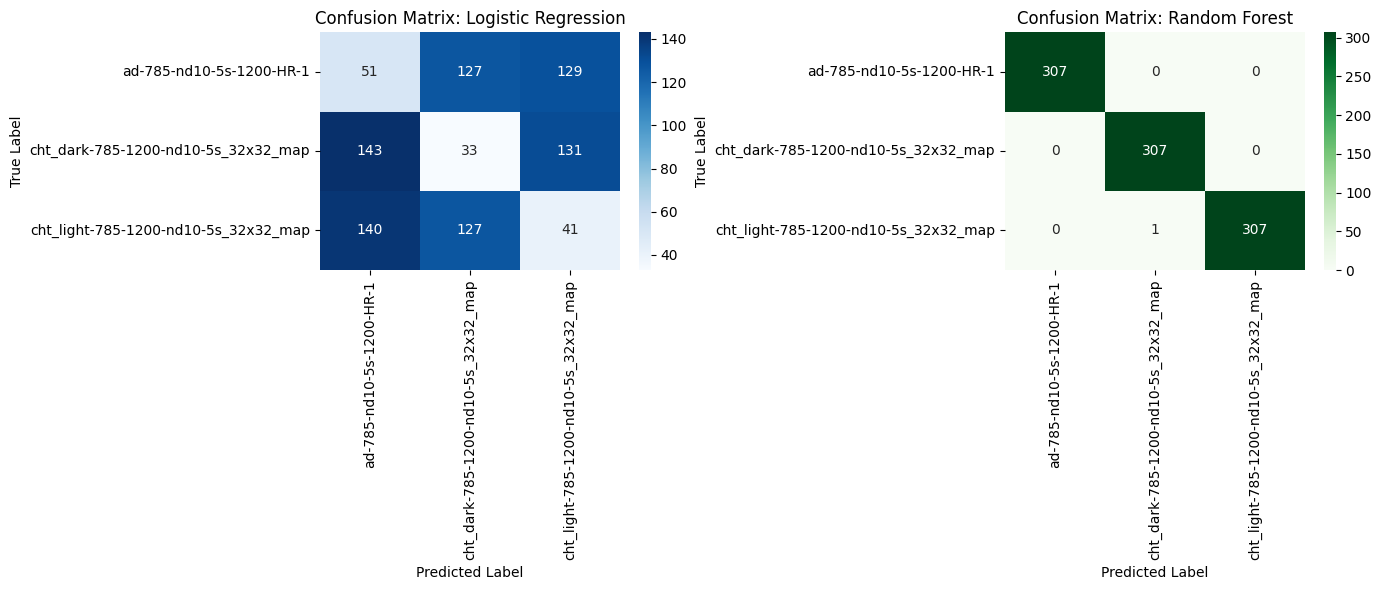

In [ ]:
# Блок 9: Классификация для 3+ классов
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    all_spectra_norm, labels, test_size=0.3, random_state=42, stratify=labels
)

print(f"Train set: {X_train.shape}, Test set: {X_test.shape}\n")

# Модель 1: Logistic Regression (multi-class)
print("=== Logistic Regression ===")
# lr = LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial')
lr = LogisticRegression(max_iter=1000, random_state=42) # i changed

lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print(classification_report(y_test, y_pred_lr, target_names=file_labels))

cv_scores_lr = cross_val_score(lr, all_spectra_norm, labels, cv=5)
print(f"Cross-validation accuracy: {cv_scores_lr.mean():.3f} (+/- {cv_scores_lr.std():.3f})\n")

# Модель 2: Random Forest
print("=== Random Forest ===")
rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print(classification_report(y_test, y_pred_rf, target_names=file_labels))

cv_scores_rf = cross_val_score(rf, all_spectra_norm, labels, cv=5)
print(f"Cross-validation accuracy: {cv_scores_rf.mean():.3f} (+/- {cv_scores_rf.std():.3f})")

# Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues',
            xticklabels=file_labels, yticklabels=file_labels, ax=axes[0])
axes[0].set_title('Confusion Matrix: Logistic Regression')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens',
            xticklabels=file_labels, yticklabels=file_labels, ax=axes[1])
axes[1].set_title('Confusion Matrix: Random Forest')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()
